# Stroke Risk Prediction & Comprehensive Analysis

**Objective:** Predict stroke risk using patient demographic and medical data, focusing on deep exploratory analysis and model performance.

**Outputs:** All visualizations and models will be saved to the `artifacts` folder.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix, roc_auc_score, recall_score, f1_score, roc_curve

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings('ignore')

# Create artifacts directory
if not os.path.exists('artifacts'):
    os.makedirs('artifacts')

# --- STYLING ---
sns.set_theme(style="whitegrid", font_scale=1.2)
custom_palette = ["#457b9d", "#e63946"] 
sns.set_palette(custom_palette)


## 1. Data Loading

In [2]:
df = pd.read_csv('data/stroke_dataset.csv')
df.drop_duplicates(inplace=True)
print(f"Dataset Shape: {df.shape}")
df.head()

Dataset Shape: (68979, 18)


,Chest Pain,Shortness of Breath,Irregular Heartbeat,Fatigue & Weakness,Dizziness,Swelling (Edema),Pain in Neck/Jaw/Shoulder/Back,Excessive Sweating,Persistent Cough,Nausea/Vomiting,High Blood Pressure,Chest Discomfort (Activity),Cold Hands/Feet,Snoring/Sleep Apnea,Anxiety/Feeling of Doom,Age,Stroke Risk (%),At Risk (Binary)
0,Absent,Present,Present,Present,Absent,Absent,Absent,Present,Present,Present,Absent,Present,Present,Absent,Absent,54,58.0,At Risk
1,Absent,Absent,Present,Absent,Absent,Present,Absent,Absent,Absent,Absent,Present,Absent,Present,Present,Absent,49,40.5,Not At Risk
2,Present,Absent,Absent,Present,Present,Present,Absent,Absent,Present,Absent,Absent,Absent,Absent,Present,Absent,62,52.0,At Risk
3,Present,Absent,Present,Present,Absent,Present,Present,Present,Present,Present,Present,Absent,Absent,Absent,Absent,48,60.0,At Risk
4,Absent,Absent,Present,Absent,Absent,Present,Absent,Present,Absent,Present,Present,Absent,Absent,Present,Present,61,56.5,At Risk


## 2. Exploratory Data Analysis (EDA)
Individual detailed plots for deep insight.

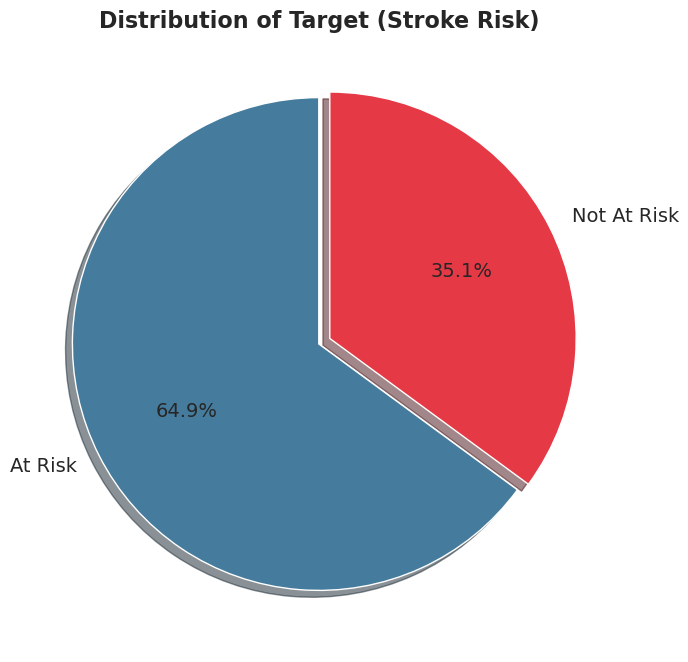

In [3]:
# 1. Target Distribution
plt.figure(figsize=(8, 8))
counts = df['At Risk (Binary)'].value_counts()
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', colors=custom_palette, 
        startangle=90, explode=(0, 0.05), shadow=True, textprops={'fontsize': 14})
plt.title('Distribution of Target (Stroke Risk)', fontsize=16, fontweight='bold')
plt.show()

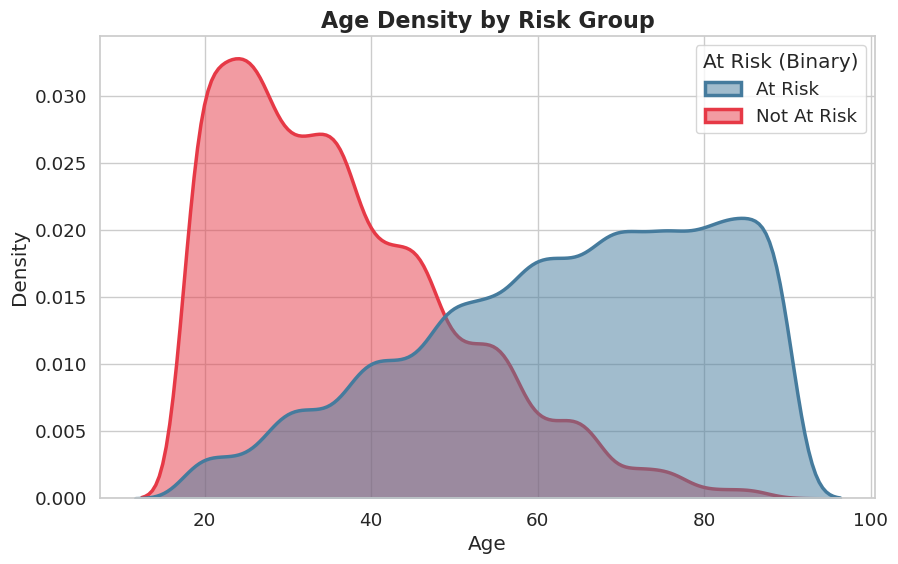

In [4]:
# 2. Age Distribution by Risk (KDE)
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='Age', hue='At Risk (Binary)', fill=True, common_norm=False, alpha=0.5, linewidth=2.5)
plt.title('Age Density by Risk Group', fontsize=16, fontweight='bold')
plt.xlabel('Age')
plt.show()

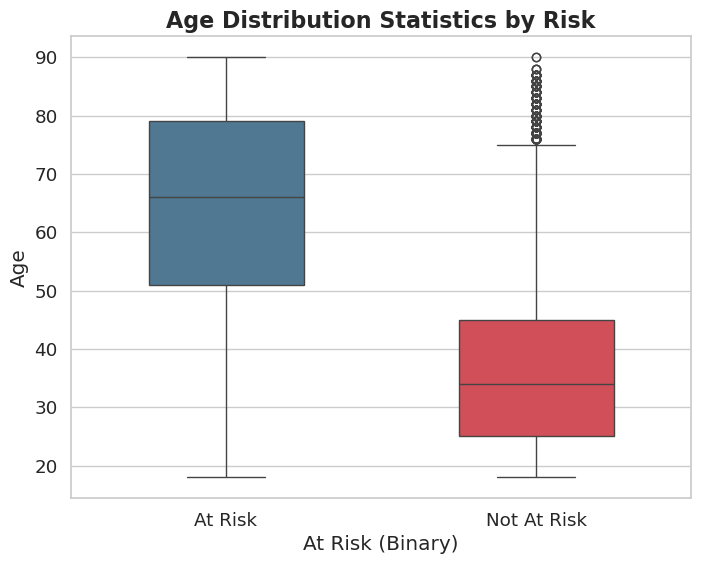

In [5]:
# 3. Age Boxplot by Risk
plt.figure(figsize=(8, 6))
sns.boxplot(x='At Risk (Binary)', y='Age', data=df, palette=custom_palette, width=0.5)
plt.title('Age Distribution Statistics by Risk', fontsize=16, fontweight='bold')
plt.show()

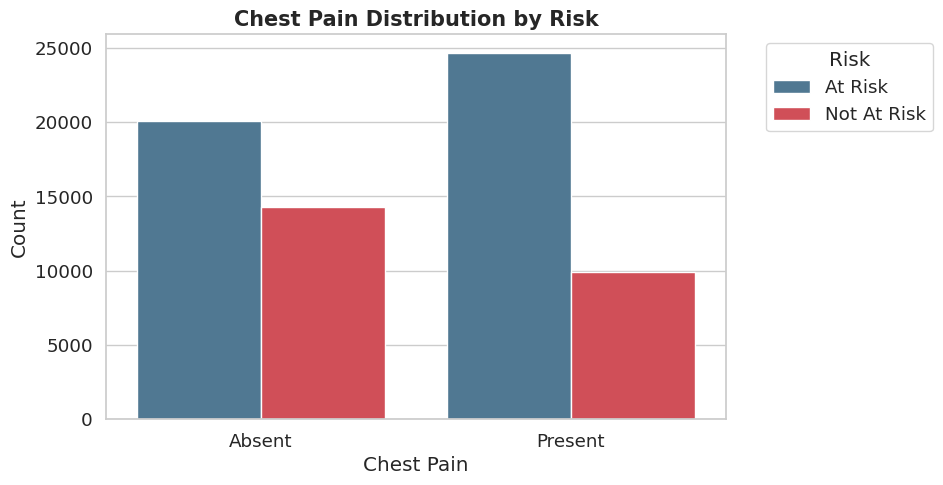

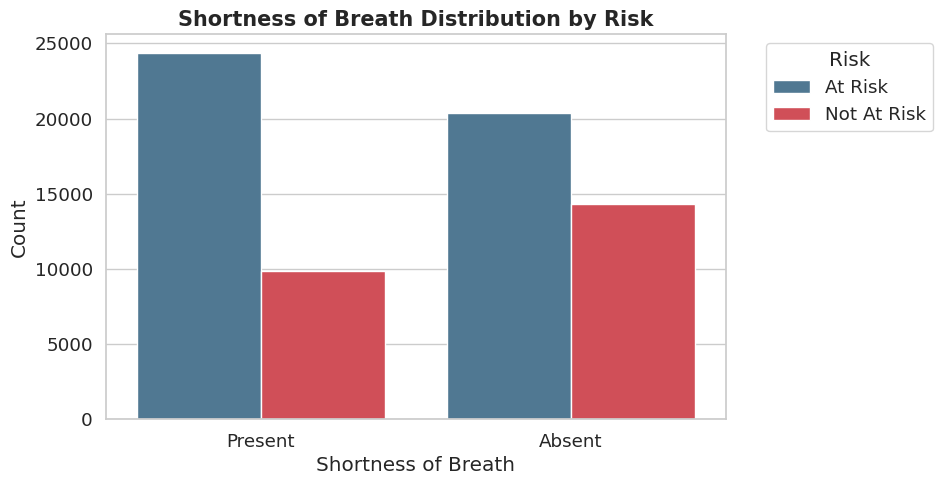

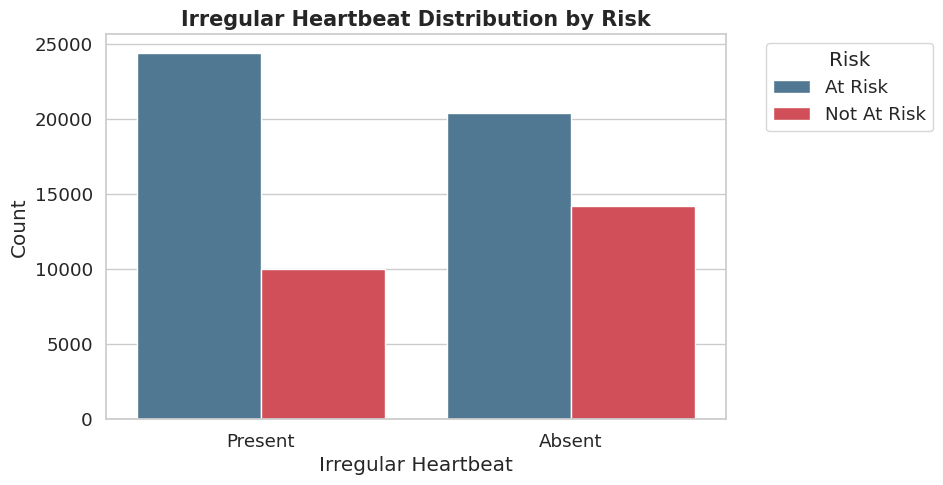

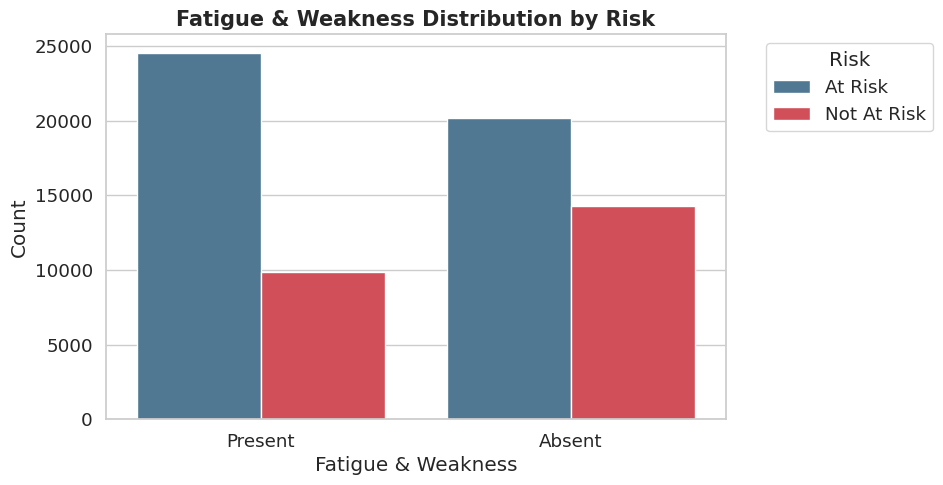

In [6]:
# 4. Categorical Feature Counts
cat_cols = [col for col in df.columns if col not in ['Age', 'Stroke Risk (%)', 'At Risk (Binary)']]
features_to_plot = cat_cols[:4] 

for col in features_to_plot:
    plt.figure(figsize=(8, 5))
    sns.countplot(x=col, hue='At Risk (Binary)', data=df, palette=custom_palette)
    plt.title(f'{col} Distribution by Risk', fontsize=15, fontweight='bold')
    plt.ylabel('Count')
    plt.legend(title='Risk', bbox_to_anchor=(1.05, 1), loc='upper left')
    safe_name = col.lower().replace(' ', '_').replace('/', '_')
    plt.show()

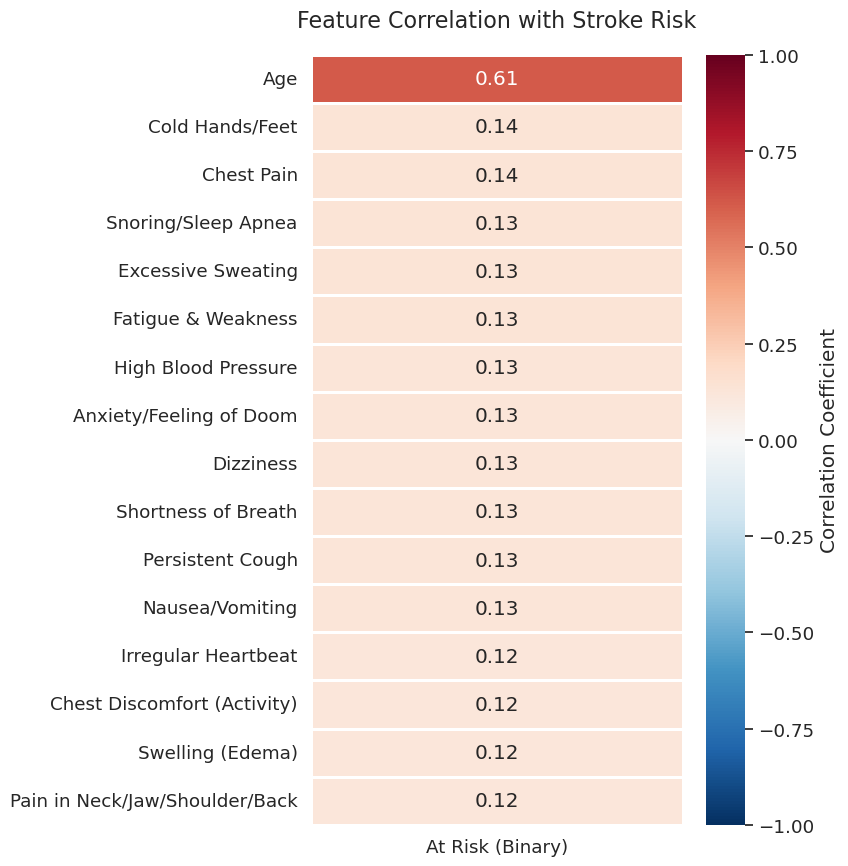

In [7]:
# 5. Correlation with Target Variable
temp_df = df.copy()
binary_map = {'Absent': 0, 'Present': 1}
target_map = {'Not At Risk': 0, 'At Risk': 1}

for col in cat_cols:
    temp_df[col] = temp_df[col].map(binary_map)
temp_df['At Risk (Binary)'] = temp_df['At Risk (Binary)'].map(target_map)

if 'Stroke Risk (%)' in temp_df.columns:
    temp_df.drop(columns=['Stroke Risk (%)'], inplace=True)

target_corr = temp_df.corr()[['At Risk (Binary)']].sort_values(by='At Risk (Binary)', ascending=False)
target_corr = target_corr.drop('At Risk (Binary)')

plt.figure(figsize=(6, 10))
sns.heatmap(target_corr, annot=True, cmap='RdBu_r', vmin=-1, vmax=1, fmt='.2f', 
            linewidths=1, linecolor='white', cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Feature Correlation with Stroke Risk', fontsize=16, pad=20)
plt.show()

In [8]:
# Preprocessing
cols_to_map = [col for col in df.columns if col not in ['Age', 'Stroke Risk (%)', 'At Risk (Binary)']]

for col in cols_to_map:
    df[col] = df[col].map(binary_map)

df['At Risk (Binary)'] = df['At Risk (Binary)'].map(target_map)

if 'Stroke Risk (%)' in df.columns:
    df = df.drop(columns=['Stroke Risk (%)'])

X = df.drop('At Risk (Binary)', axis=1)
y = df['At Risk (Binary)']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale Age
scaler = StandardScaler()
X_train['Age'] = scaler.fit_transform(X_train[['Age']])
X_test['Age'] = scaler.transform(X_test[['Age']])

print("Preprocessing Complete.")

Preprocessing Complete.


In [9]:
# Model Training
models = {
    'Logistic Regression': LogisticRegression(max_iter=10, class_weight='balanced'),
    'Decision Tree': DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Support Vector Machine': SVC(probability=True, random_state=42, class_weight='balanced')
}

results = []
trained_models = {}

print("Training models...")
for name, model in models.items():
    model.fit(X_train, y_train)
    trained_models[name] = model
    
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),  
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_prob)
    })
    print(f"{name} Done.")

results_df = pd.DataFrame(results).sort_values(by='Recall', ascending=False)

# !!! DEFINING BEST MODEL OBJECT HERE to avoid NameErrors !!!
best_model_name = results_df.iloc[0]['Model']
best_model_obj = trained_models[best_model_name]
print(f"\nBest Model Identified: {best_model_name}")

results_df

Training models...
Logistic Regression Done.
Decision Tree Done.
Random Forest Done.
Gradient Boosting Done.
Support Vector Machine Done.

Best Model Identified: Support Vector Machine


,Model,Accuracy,Recall,F1,AUC
4,Support Vector Machine,0.988112,0.982918,0.990772,0.999798
3,Gradient Boosting,0.957524,0.981579,0.967749,0.991121
2,Random Forest,0.946361,0.967288,0.959044,0.990526
0,Logistic Regression,0.976080,0.963157,0.981233,0.999895
1,Decision Tree,0.880183,0.916490,0.908527,0.864734


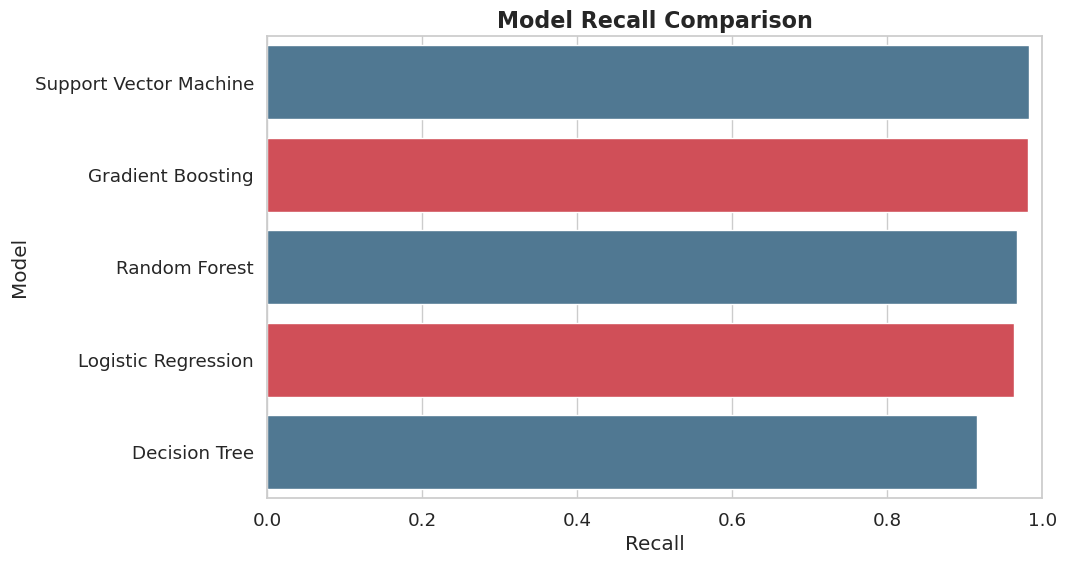

In [10]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Recall', y='Model', data=results_df, palette=custom_palette)
plt.title('Model Recall Comparison', fontsize=16, fontweight='bold')
plt.xlim(0, 1)
plt.show()

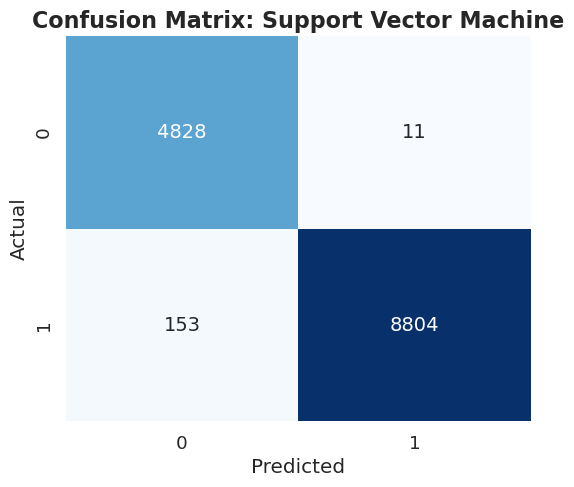

In [11]:
# Now best_model_obj is definitely defined
y_pred_best = best_model_obj.predict(X_test)

cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={'size': 14})
plt.title(f'Confusion Matrix: {best_model_name}', fontsize=16, fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [12]:
# Save Models to artifacts
joblib.dump(best_model_obj, 'artifacts/best_stroke_model.pkl')
joblib.dump(scaler, 'artifacts/scaler.pkl')
print("Saved models to artifacts folder.")

Saved models to artifacts folder.
